教師あり機械学習モデルの適用手順
1. モデルのクラスを選択する
2. モデルのハイパーパラメータを選択する
3. モデルに学習用データを当てはめる
4. モデルを使って新しいデータのラベルを予測する

## 5.3.1 モデル検証に関する考察

### 5.3.1.1 誤ったモデル検証方法

In [1]:
from sklearn.datasets import load_iris #データの読み込み
iris = load_iris()
X = iris.data #特徴マトリクス（nサンプル, n特徴）
y = iris.target #目的配列(nサンプル)

In [4]:
from sklearn.neighbors import KNeighborsClassifier  #モデルとハイパーパラメータの選択
model = KNeighborsClassifier(n_neighbors=1)

In [7]:
model.fit(X, y) #モデルの学習と、既知データの予測
y_model = model.predict(X)

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

### 5.3.1.1 正しいモデル検証法：ホールドアウトセット

``ホールドアウトセット`` モデルの学習で使用するデータを分割し、サブセットを使用してモデルの性能を検証する

In [11]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, test_size = 0.5) #データを50%に分割

model.fit(X1, y1) #一方のデータセットで学習

y2_model = model.predict(X2) #他方のデータセットでモデルを検証する
accuracy_score(y2, y2_model)

0.9066666666666666

### 5.3.1.3 交差検証によるモデルの検証

``交差検証`` それぞれのデータのサブセットを学習データ・検証データとして順番に使用する

In [12]:
#2分割した交差検証
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

In [13]:
#5分割交差検証
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

``leave-one-out交差検証`` 各施行で1つのデータを覗いたすべてのデータを使って学習する

In [15]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
#エラー率の推定値を検証
scores.mean()

0.96

## 5.3.2 最適なモデルの選択

### 5.3.2.1 バイアス-バリアンス トレードオフ

1. ``適合不足(underfit)`` データのすべての特徴を適切に説明するのに十分なモデルの柔軟性がない →``高バイアス``
2. ``過剰適合(overfit0`` モデルの柔軟性が非常に高いために、データの分散とランダムなエラーの両方を考慮してしまう→``高バリアンス``

$R^2$ : ``決定係数`` 目標値の平均に対してモデルがどれだけうまく実行されるかを表す
 - 高バリアスモデルでは、検証データに対する性能は学習データと同程度
 - 高バリアンスモデルでは、検証データに対する性能は学習データよりも悪くなる

### 5.3.2.2 scikit-learnを使った検証曲線の作成

 - 次数1の多項式：$y=ax+b$
 - 次数3の多項式：$y=ax^3+bx^2+cx+d$

In [18]:
#単回帰と多項式プリプロセッサの組み合わせで、実装。パイプラインを使用
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [19]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

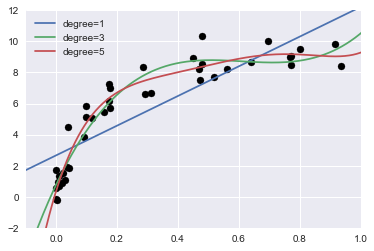

In [21]:
#データセットに当てはめた3種類の多項式
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

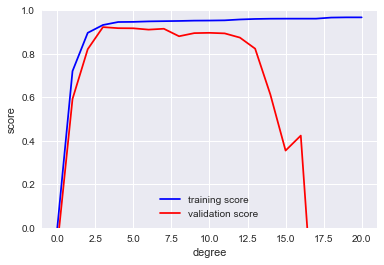

In [25]:
#検証曲線を可視化
from sklearn.learning_curve import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7) #validation_curve(モデル, データ, パラメータ名, 探索範囲)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

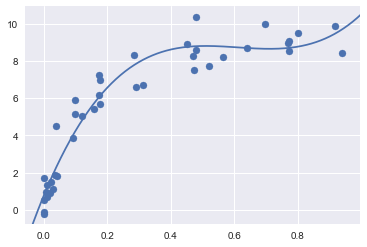

In [29]:
#交差検証によって求めた最適モデル
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

## 5.3.3 学習曲線

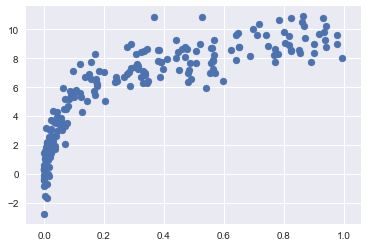

In [33]:
#ポイントを5倍にして新しいデータセットを生成
X2,y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

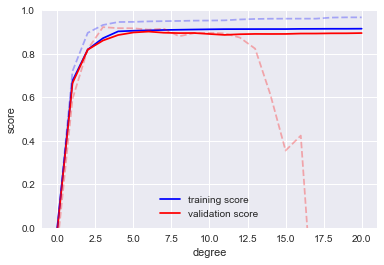

In [35]:
#前のプロットに上書きして検証
#実線：新しい結果
#破線：前の小さなデータセットの結果
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

検証曲線の挙動は以下に影響を受ける
 - モデルの複雑さ
 - 学習データの量

``学習曲線``: 学習セットのサイズに関する学習スコアと検証スコアのプロット（x軸が学習データのサイズとなる）
 - ある複雑さのモデルでは、小さなデータセットに対して過剰適合する。検証スコアが比較的低いのに対し学習スコアが比較的高い
 - ある複雑さのモデルでは、大きなデータセットには適合不足となる。学習スコアが減少するのに対し、検証スコアが増加することを意味する。
 - 偶然を除き、学習セットよりも検証セットの方が良いスコアになることはない。

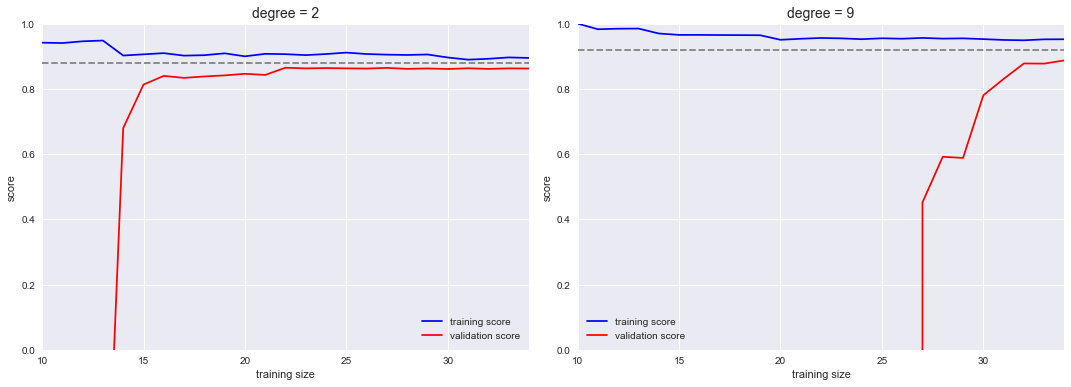

In [41]:
#複雑さの低いモデルと複雑なモデルの学習曲線
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

## 5.3.4 検証の実線：グリッドサーチ

``グリッドサーチ``：最適な多項式モデルを見つける例を示す。
グリッドは3次元の特徴（多項式の次数、切片に合わせるかどうかを示すフラグ、及び問題を正規化するかどうかを示すフラグ）からなる

In [42]:
from sklearn.grid_search import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

/Users/shoki/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [43]:
grid.fit(X, y);

In [45]:
#最もスコアの高いパラメータを求める
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

/Users/shoki/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:3259: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


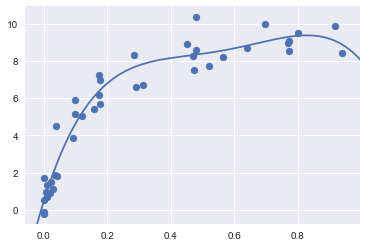

In [47]:
#最良モデルの結果を可視化
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True);
plt.axis(lim);